In [91]:
#Includes necesarios
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split

from auxiliar import get_train_set,get_holdout_set,create_prediction
import preprocessing as pr

from auxiliar import plot_cm,plot_tree
from sklearn.metrics import classification_report,plot_roc_curve

# KNN

Important thing to note in k-NN algorithm is the that the number of features and the number of classes both don't play a part in determining the value of k in k-NN algorithm. k-NN algorithm is an ad-hoc classifier used to classify test data based on distance metric, i.e a test sample is classified as Class-1 if there are more number of Class-1 training samples closer to the test sample compared to other Classes training samples. 

Coming to your question, the value of k is non-parametric and a general rule of thumb in choosing the value of k is k = sqrt(N)/2, where N stands for the number of samples in your training dataset. Another tip that I suggest is to try and keep the value of k odd, so that there is no tie between choosing a class but that points to the fact that training data is highly correlated between classes and using a simple classification algorithm such as k-NN would result in poor classification performance.

Los hiperparametros que consideramos relevantes para un modelo como el de KNN (k-nearest neighbors) son:
   - n_neighbors (K): cantidad de vecinos, se aconseja que sea impar para evitar que la prediccion sea aleatoria cuando haya la misma cantidad de vecinos
   - weights: El peso que se le da a la distancia entre los puntos.
   - metric: La funcion para calcular la distancia entre los puntos.

Obtenemos el dataset con el cual entrenaremos nuestro modelo:

In [92]:
X,y = get_train_set(missings='category')

## Preprocesamiento 1:

In [93]:
X_fe = pr.preprocesado1(X)

Para entrenar el arbol necesitamos aplicar OHE en las columnas categoricas, para esto llamamos a la funcion de preprocesamiento **aplicar_OHE**:

In [94]:
pr.init_OHE(X_fe)

In [95]:
X_ohe = pr.apply_OHE(X_fe)

Partimos nuestro set en *train* y *validation*:

In [96]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe,y, test_size=0.2, random_state=19, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.
Tardo 10 a 12 minutos sin n_jobs = -1

In [97]:
parameters = {
    'n_neighbors': [43,101,151,199,251,307],
    'weights': ['uniform','distance'],
}

clf = KNeighborsClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, return_train_score=True,verbose=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best score: 0.890637271816562
Best params {'n_neighbors': 43, 'weights': 'uniform'}


Armo el modelo de arbol de decision con los hiperparametros calculados:

In [98]:
model_knn = gscv.best_estimator_

Entreno el modelo con el train set:

In [99]:
model_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=43)

Predigo con el validation set:

In [100]:
knn_predict = model_knn.predict(X_validation)

**Metricas**

In [101]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4945
           1       0.73      0.57      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.75      0.77      6513
weighted avg       0.84      0.85      0.84      6513



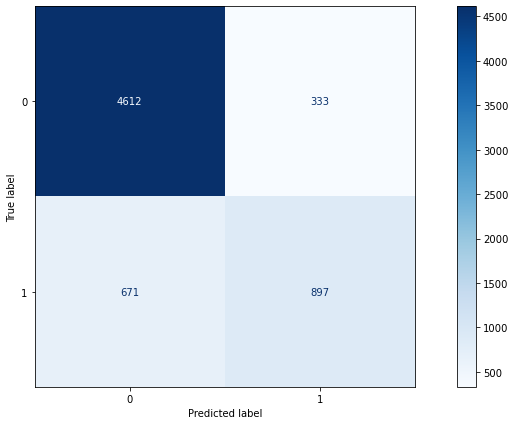

In [102]:
plot_cm(model_knn, X_validation, y_validation)

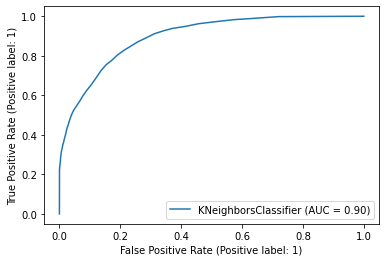

In [103]:
plot_roc_curve(model_knn, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 1 + Estandarizacion: 

Probaremos ahora como es el rendimiento del modelo KNN aplicando el mismo preprocesamiento y una estandarizacion.Para esto reutilizaremos **X_ohe** que es el resultado de haber preprocesado y aplicar OHE.

In [104]:
X_standar = pr.standarize(X_ohe)

Partimos nuestro set en *train* y *validation*:

In [105]:
X_standar_train, X_standar_validation, y_train, y_validation = train_test_split(X_standar,y, test_size=0.2, random_state=19, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.
Tarda entre 10 a 12 minutos sin n_jobs = -1

In [106]:
parameters = {
    'n_neighbors': [43,101,151,199,251,307],
    'weights': ['uniform','distance'],
}

clf = KNeighborsClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, return_train_score=True,verbose=True
).fit(X_standar_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best score: 0.8819156825919083
Best params {'n_neighbors': 43, 'weights': 'uniform'}


Armo el modelo de arbol de decision con los hiperparametros calculados:

In [107]:
model_knn_standar = gscv.best_estimator_

Entreno el modelo con el train set:

In [108]:
model_knn_standar.fit(X_standar_train, y_train)

KNeighborsClassifier(n_neighbors=43)

Predigo con el validation set:

In [109]:
knn_predict = model_knn_standar.predict(X_standar_validation)

**Metricas**

In [110]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4945
           1       0.70      0.56      0.62      1568

    accuracy                           0.83      6513
   macro avg       0.78      0.74      0.76      6513
weighted avg       0.83      0.83      0.83      6513



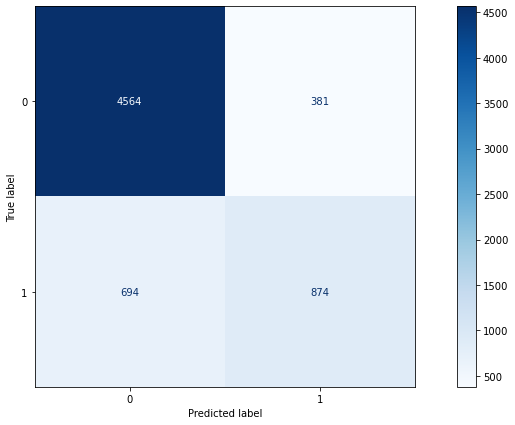

In [111]:
plot_cm(model_knn_standar, X_standar_validation, y_validation)

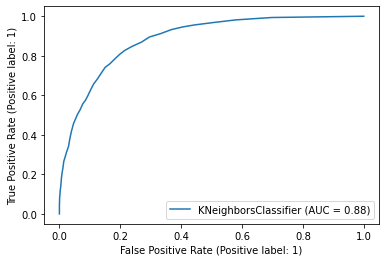

In [112]:
plot_roc_curve(model_knn_standar, X_standar_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 1 + Normalizacion:

Probaremos ahora como es el rendimiento del modelo KNN aplicando el mismo preprocesamiento y una normalizacion.Para esto reutilizaremos **X_ohe** que es el resultado de haber preprocesado y aplicar OHE.

In [113]:
X_normalized = pr.normalize(X_ohe)

Partimos nuestro set en *train* y *validation*:

In [114]:
X_normalized_train, X_normalized_validation, y_train, y_validation = train_test_split(X_normalized,y, test_size=0.2, random_state=19, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.
Tarda entre 10 a 12 minutos sin n_jobs = -1

In [115]:
parameters = {
    'n_neighbors': [43,101,151,199,251,307],
    'weights': ['uniform','distance'],
    'metric': ['cosine']
}

clf = KNeighborsClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc', cv=5, return_train_score=True,verbose=True
).fit(X_normalized_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best score: 0.8645029679389937
Best params {'metric': 'cosine', 'n_neighbors': 43, 'weights': 'uniform'}


Armo el modelo de arbol de decision con los hiperparametros calculados:

In [116]:
model_knn_normalized = gscv.best_estimator_

Entreno el modelo con el train set:

In [117]:
model_knn_normalized.fit(X_normalized_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=43)

Predigo con el validation set:

In [118]:
knn_predict = model_knn_normalized.predict(X_normalized_validation)

**Metricas**

In [119]:
print(classification_report(y_validation, knn_predict))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4945
           1       0.66      0.59      0.62      1568

    accuracy                           0.83      6513
   macro avg       0.76      0.75      0.75      6513
weighted avg       0.82      0.83      0.82      6513



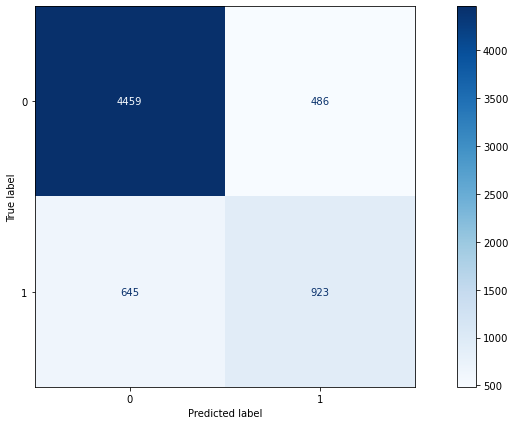

In [120]:
plot_cm(model_knn_normalized, X_normalized_validation, y_validation)

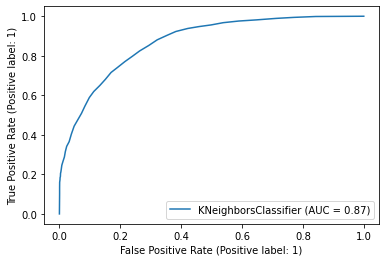

In [121]:
plot_roc_curve(model_knn_normalized, X_normalized_validation, y_validation, response_method="predict_proba")
plt.show()

# Conclusión

# Predicción

In [122]:
ids, X_holdout = get_holdout_set(missings='category')

In [123]:
pr.init_OHE(X_fe)

In [124]:
X_holdout_fe = pr.preprocesado1(X_holdout)

In [125]:
X_holdout_ohe = pr.apply_OHE(X_holdout_fe)

In [126]:
knn_predict = model_knn.predict(X_holdout_ohe)

In [127]:
create_prediction(ids,knn_predict,file_name='knn')